In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'BSET.csv'
data = pd.read_csv(file_path)

In [3]:
data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,17-03-1980,7.040000,0.0,57891,7.360000,7.040000,1.669888
1,18-03-1980,6.933333,0.0,8203,7.253333,6.933333,1.644587
2,19-03-1980,6.826667,0.0,938,7.146667,6.826667,1.619286
3,20-03-1980,6.826667,0.0,1875,7.146667,6.826667,1.619286
4,21-03-1980,6.720000,0.0,9375,7.040000,6.720000,1.593984


In [4]:
data.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,10778.000000,10778.000000,1.077800e+04,10778.000000,10778.000000,10778.000000
mean,18.457669,17.263284,3.486521e+04,19.049480,18.745437,8.284443
std,7.734083,9.462555,5.279960e+04,7.957894,7.855099,5.952886
min,0.620000,0.000000,0.000000e+00,0.850000,0.790000,0.452214
25%,13.437500,12.160000,1.068800e+04,13.922500,13.650000,4.678138
50%,18.350000,18.139999,2.250000e+04,18.868334,18.639999,6.531633
75%,23.600000,23.600000,4.264200e+04,24.250000,23.939375,9.055912
max,43.200001,43.799999,1.488600e+06,44.000000,43.799999,32.141068


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10778 entries, 0 to 10777
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10778 non-null  object 
 1   Low             10778 non-null  float64
 2   Open            10778 non-null  float64
 3   Volume          10778 non-null  int64  
 4   High            10778 non-null  float64
 5   Close           10778 non-null  float64
 6   Adjusted Close  10778 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 589.6+ KB


In [6]:
data.isnull().sum() # there is no missing values in the provided dataset

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

### Model Implementation

In [7]:
import tensorflow as tf
import random
import os

In [8]:
def set_seed(seed=42):
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(42)

#### Pre-process

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


from itertools import product
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, SimpleRNN,  Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

In [10]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        target = data[i + window_size][0]  # predicting 'Close' price
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

### Model Test and Evaluation

In [11]:
# split data into training + validation and test sets
features = data[['Close', 'Volume']]

total_samples = len(features)
train_val_size = int(total_samples * 0.85)
test_size = total_samples - train_val_size

train_val_data = features[:train_val_size]
test_data = features[train_val_size:]

# Scaling
scaler = MinMaxScaler()
train_val_scaled = scaler.fit_transform(train_val_data)
test_scaled = scaler.transform(test_data)

In [12]:
print(train_val_data.shape, test_data.shape)

(9161, 2) (1617, 2)


In [13]:
window_size = 5

X_train_val, y_train_val = create_sequences(train_val_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

n_features = X_train_val.shape[2]
X_train_val = X_train_val.reshape((X_train_val.shape[0], X_train_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

##### Train and Fit

In [14]:
set_seed(42)

In [15]:
# define models
def create_lstm_model(window_size, n_features, learning_rate, hidden_units, dropout_rate, fc_size):
	model = Sequential()
	model.add(Input(shape=(window_size, n_features)))
	model.add(LSTM(hidden_units))
	model.add(Dropout(dropout_rate))
	model.add(Dense(fc_size, activation='relu'))
	model.add(Dense(1))
	optimizer = Adam(learning_rate=learning_rate) # refer to github work original set up number
	criterion = MeanSquaredError(reduction='sum_over_batch_size')
	model.compile(optimizer, loss=criterion)
	return model

def create_gru_model(window_size, n_features, learning_rate, hidden_units, dropout_rate, fc_size):
	model = Sequential()
	model.add(Input(shape=(window_size, n_features)))
	model.add(GRU(hidden_units))
	model.add(Dropout(dropout_rate))
	model.add(Dense(fc_size, activation='relu'))
	model.add(Dense(1))
	optimizer = Adam(learning_rate=learning_rate) # refer to github work original set up number
	criterion = MeanSquaredError(reduction='sum_over_batch_size')
	model.compile(optimizer, loss=criterion)
	return model

def create_rnn_model(window_size, n_features, learning_rate, hidden_units, dropout_rate, fc_size):
	model = Sequential()
	model.add(Input(shape=(window_size, n_features)))
	model.add(SimpleRNN(hidden_units, activation='tanh'))
	model.add(Dropout(dropout_rate))
	model.add(Dense(fc_size, activation='relu'))
	model.add(Dense(1))
	optimizer = Adam(learning_rate=learning_rate) # refer to github work original set up number
	criterion = MeanSquaredError(reduction='sum_over_batch_size')
	model.compile(optimizer, loss=criterion)
	return model

In [16]:
rnn_params = {'learning_rate': 5e-4,'hidden_units': 128, 'dropout_rate': 0.1, 'fc_size': 16}
lstm_params = {'learning_rate': 1e-4,'hidden_units': 64, 'dropout_rate': 0.1, 'fc_size': 8}
gru_params = {'learning_rate': 1e-4, 'hidden_units': 64, 'dropout_rate': 0.3, 'fc_size': 32}

In [17]:
model_rnn = create_rnn_model(window_size, n_features, **rnn_params)
model_lstm = create_lstm_model(window_size, n_features, **lstm_params)
model_gru = create_gru_model(window_size, n_features, **gru_params)

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
callbacks = [reduce_lr]

In [19]:
history_lstm = model_lstm.fit(X_train_val, y_train_val, epochs=30, batch_size=32, shuffle=False, callbacks=callbacks, verbose=0)
history_gru = model_gru.fit(X_train_val, y_train_val, epochs=30, batch_size=32, shuffle=False, callbacks=callbacks, verbose=0)
history_rnn = model_rnn.fit(X_train_val, y_train_val, epochs=30, batch_size=32, shuffle=False,callbacks=callbacks, verbose=0)

##### Test Evaluaiton

In [20]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)
y_pred_rnn = model_rnn.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [21]:
y_pred_lstm_inv = scaler.inverse_transform(np.concatenate([y_pred_lstm, np.zeros((y_pred_lstm.shape[0], n_features - 1))], axis=1))[:, 0]
y_pred_gru_inv = scaler.inverse_transform(np.concatenate([y_pred_gru, np.zeros((y_pred_gru.shape[0], n_features - 1))], axis=1))[:, 0]
y_pred_rnn_inv = scaler.inverse_transform(np.concatenate([y_pred_rnn, np.zeros((y_pred_rnn.shape[0], n_features - 1))], axis=1))[:, 0]

y_test_actual_inv  = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], n_features - 1))], axis=1))[:, 0]

In [22]:
test_lstm_rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_pred_lstm_inv))
test_lstm_mae = mean_absolute_error(y_test_actual_inv, y_pred_lstm_inv)
test_lstm_mape = mean_absolute_percentage_error(y_test_actual_inv, y_pred_lstm_inv) * 100
test_lstm_direction_actual = np.sign(np.diff(y_test_actual_inv))
test_lstm_direction_pred = np.sign(np.diff(y_pred_lstm_inv))
test_lstm_directional_accuracy = np.mean(test_lstm_direction_actual == test_lstm_direction_pred) * 100

In [23]:
test_gru_rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_pred_gru_inv))
test_gru_mae = mean_absolute_error(y_test_actual_inv, y_pred_gru_inv)
test_gru_mape = mean_absolute_percentage_error(y_test_actual_inv, y_pred_gru_inv) * 100
test_gru_direction_actual = np.sign(np.diff(y_test_actual_inv))
test_gru_direction_pred = np.sign(np.diff(y_pred_gru_inv))
test_gru_directional_accuracy = np.mean(test_gru_direction_actual == test_gru_direction_pred) * 100

In [24]:
test_rnn_rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_pred_rnn_inv))
test_rnn_mae = mean_absolute_error(y_test_actual_inv, y_pred_rnn_inv)
test_rnn_mape = mean_absolute_percentage_error(y_test_actual_inv, y_pred_rnn_inv) * 100
test_rnn_direction_actual = np.sign(np.diff(y_test_actual_inv))
test_rnn_direction_pred = np.sign(np.diff(y_pred_rnn_inv))
test_rnn_directional_accuracy = np.mean(test_rnn_direction_actual == test_rnn_direction_pred) * 100

In [25]:
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'SimpleRNN'],
    'Leanring Rate':  [lstm_params['learning_rate'], gru_params['learning_rate'], rnn_params['learning_rate']],
    'Hidden Units': [lstm_params['hidden_units'], gru_params['hidden_units'], rnn_params['hidden_units']],
    'Dropout Rate': [lstm_params['dropout_rate'], gru_params['dropout_rate'], rnn_params['dropout_rate']],
    'FC Size': [lstm_params['fc_size'], gru_params['fc_size'], rnn_params['fc_size']],
    'RMSE': [test_lstm_rmse, test_gru_rmse, test_rnn_rmse],
    'MAE': [test_lstm_mae, test_gru_mae, test_rnn_mae],
    'MAPE (%)': [test_lstm_mape, test_gru_mape, test_rnn_mape],
    'Directional Accuracy (%)': [
        test_lstm_directional_accuracy,
        test_gru_directional_accuracy,
        test_rnn_directional_accuracy
    ]
})

# Display the DataFrame
print(results)

       Model  Leanring Rate  Hidden Units  Dropout Rate  FC Size      RMSE  \
0       LSTM         0.0001            64           0.1        8  1.046244   
1        GRU         0.0001            64           0.3       32  1.047924   
2  SimpleRNN         0.0005           128           0.1       16  0.754674   

        MAE  MAPE (%)  Directional Accuracy (%)  
0  0.734941  3.910346                 49.410304  
1  0.842130  4.796810                 49.037865  
2  0.596508  3.256636                 47.486034  


##### Visiluization

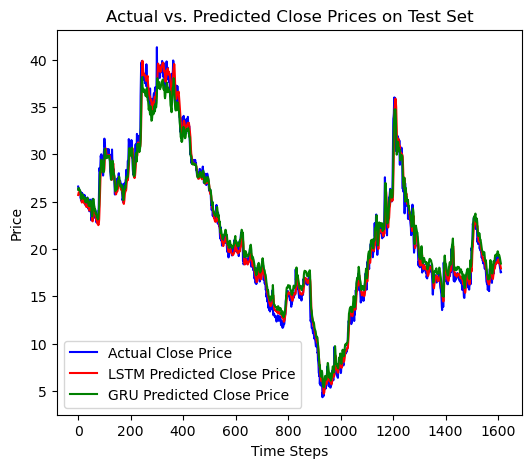

In [30]:
plt.figure(figsize=(6, 5))
plt.plot(y_test_actual_inv, label='Actual Close Price', color='blue')
plt.plot(y_pred_lstm_inv, label='LSTM Predicted Close Price', color='red')
plt.plot(y_pred_gru_inv, label='GRU Predicted Close Price', color='green')
# plt.plot(y_pred_rnn_inv, label='RNN Predicted Close Price', color='orange')
plt.title('Actual vs. Predicted Close Prices on Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

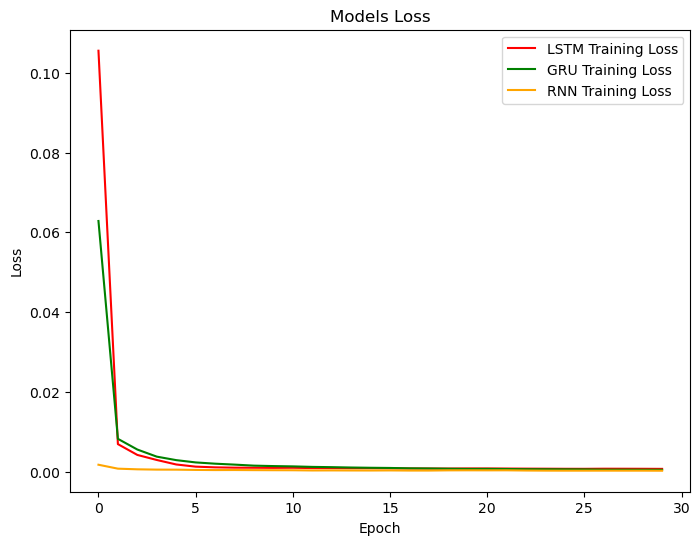

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss', color='red')
plt.plot(history_gru.history['loss'], label='GRU Training Loss', color='green')
plt.plot(history_rnn.history['loss'], label='RNN Training Loss', color='orange')
plt.title('Models Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()